In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from collections import defaultdict
import torch
import torch.nn as nn
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
import time
import cv2
from tqdm import tqdm
import copy
from torch.nn.modules.distance import PairwiseDistance

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import datagen
def get_dataloader(train_root_dir,
                   train_csv_name,
                   num_train_triplets, num_valid_triplets,
                   batch_size, num_workers):

    face_dataset = {'train': datagen.TripletFaceDataset(root_dir=train_root_dir,csv_name=train_csv_name,
                                                num_triplets=num_train_triplets,transform=None,train=True),
                    'valid': datagen.TripletFaceDataset(root_dir=train_root_dir,csv_name=train_csv_name,
                                    num_triplets=num_valid_triplets,transform=None,train=False)}

    dataloaders = {x: torch.utils.data.DataLoader(face_dataset[x], batch_size=batch_size, shuffle=True, num_workers=num_workers)
        for x in ['train', 'valid']}
    
    data_size = {x: len(face_dataset[x]) for x in ['train', 'valid']}
    return dataloaders, data_size

In [4]:
folder_dir = 'dataset/images/'
train_csv_name ='file.csv'
data_loaders, data_size = get_dataloader(train_root_dir = folder_dir,
                                                train_csv_name = train_csv_name,
                                                num_train_triplets = 1120, num_valid_triplets = 1120,
                                                batch_size = 8,num_workers=0)

In [5]:
import googlenet
model= googlenet.GoogLeNet().to(device)

In [7]:
from torchsummary import summary
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
            Conv2d-2         [-1, 64, 112, 112]           9,408
       BatchNorm2d-3         [-1, 64, 112, 112]             128
       BatchNorm2d-4         [-1, 64, 112, 112]             128
              ReLU-5         [-1, 64, 112, 112]               0
              ReLU-6         [-1, 64, 112, 112]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           4,096
           Conv2d-10           [-1, 64, 56, 56]           4,096
      BatchNorm2d-11           [-1, 64, 56, 56]             128
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
             ReLU-14           [-1, 64,

In [6]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 100
start = time.time()

In [7]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

criterion=TripletLoss().to(device)

In [8]:
def train(dataloader,epoch):
        model.train()
        losses=0
        for batch_idx, batch_sample in tqdm(enumerate(dataloader)):
            model.zero_grad()
            anchor_embedding=model(batch_sample["anc_img"].to(torch.float).to(device))
            positive_embedding=model(batch_sample["pos_img"].to(torch.float).to(device))
            negative_embedding=model(batch_sample["neg_img"].to(torch.float).to(device))
            
            loss=criterion(anchor_embedding,positive_embedding,negative_embedding)
            loss.backward()
            optimizer.step()
            losses+=loss.item()
        epoch_loss=losses/len(dataloader)
        return epoch_loss

In [9]:
def evaluate(dataloader,epoch):    
        model.eval()
        val_loss_value=0
        with torch.no_grad():
            for batch_idx, batch_sample in tqdm(enumerate(dataloader)):
                anchor_embedding=model(batch_sample["anc_img"].to(torch.float).to(device))
                positive_embedding=model(batch_sample["pos_img"].to(torch.float).to(device))
                negative_embedding=model(batch_sample["neg_img"].to(torch.float).to(device))
                
                loss=criterion(anchor_embedding,positive_embedding,negative_embedding)
                val_loss_value+=loss.item()
            val_epoch_loss=val_loss_value/len(dataloader)
        return val_epoch_loss

In [10]:
best_loss=999
losses=[]
training = []
validation = []

for epoch in range(num_epochs):
        train_loss=train(data_loaders['train'],epoch)
        print(f"TRAINING STEP: {epoch} LOSS: {train_loss}")
        training.append(train_loss)

        val_loss=evaluate(data_loaders['valid'],epoch)
        print(f"VALIDATING STEP: {epoch} LOSS: {val_loss}")
        validation.append(val_loss)
        
        if val_loss<best_loss:
            best_loss=val_loss
            print("Saving Best Model ",epoch)
            torch.save(model.state_dict(),os.path.join("","best_model.pth"))

140it [01:55,  1.21it/s]
0it [00:00, ?it/s]

TRAINING STEP: 0 LOSS: 0.46346484598304544


140it [01:09,  2.03it/s]


VALIDATING STEP: 0 LOSS: 0.38040834670620305
Saving Best Model  0


140it [01:36,  1.45it/s]
0it [00:00, ?it/s]

TRAINING STEP: 1 LOSS: 0.294932561101658


140it [01:06,  2.09it/s]


VALIDATING STEP: 1 LOSS: 0.3089173502687897
Saving Best Model  1


140it [01:36,  1.46it/s]
0it [00:00, ?it/s]

TRAINING STEP: 2 LOSS: 0.20714033363120896


140it [01:05,  2.13it/s]


VALIDATING STEP: 2 LOSS: 0.23746271575135844
Saving Best Model  2


140it [01:35,  1.46it/s]
0it [00:00, ?it/s]

TRAINING STEP: 3 LOSS: 0.17390003449150493


140it [01:04,  2.16it/s]


VALIDATING STEP: 3 LOSS: 0.18708097423825945
Saving Best Model  3


140it [01:35,  1.46it/s]
0it [00:00, ?it/s]

TRAINING STEP: 4 LOSS: 0.13306684573846203


140it [01:05,  2.13it/s]


VALIDATING STEP: 4 LOSS: 0.1562074583555971
Saving Best Model  4


140it [01:38,  1.41it/s]
0it [00:00, ?it/s]

TRAINING STEP: 5 LOSS: 0.110269048171384


140it [01:15,  1.85it/s]


VALIDATING STEP: 5 LOSS: 0.1440413040774209
Saving Best Model  5


140it [02:00,  1.16it/s]
0it [00:00, ?it/s]

TRAINING STEP: 6 LOSS: 0.09675915353000164


140it [01:22,  1.69it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 6 LOSS: 0.147847113811544


140it [01:55,  1.21it/s]
0it [00:00, ?it/s]

TRAINING STEP: 7 LOSS: 0.08169640100428037


140it [01:24,  1.66it/s]


VALIDATING STEP: 7 LOSS: 0.11814300252922944
Saving Best Model  7


140it [17:07,  7.34s/it] 
0it [00:00, ?it/s]

TRAINING STEP: 8 LOSS: 0.08054313393575804


140it [00:42,  3.29it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 8 LOSS: 0.1324411241603749


140it [00:40,  3.50it/s]
1it [00:00,  6.39it/s]

TRAINING STEP: 9 LOSS: 0.07023972714585917


140it [00:24,  5.60it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 9 LOSS: 0.11957453851188932


140it [00:33,  4.14it/s]
1it [00:00,  5.80it/s]

TRAINING STEP: 10 LOSS: 0.06624007554990904


140it [00:25,  5.58it/s]


VALIDATING STEP: 10 LOSS: 0.11667529972536224
Saving Best Model  10


140it [00:34,  4.10it/s]
1it [00:00,  5.63it/s]

TRAINING STEP: 11 LOSS: 0.054127211815544536


140it [00:24,  5.61it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 11 LOSS: 0.12775852472654411


140it [00:34,  4.10it/s]
1it [00:00,  6.00it/s]

TRAINING STEP: 12 LOSS: 0.052974606465016096


140it [00:26,  5.36it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 12 LOSS: 0.12219357559723514


140it [00:34,  4.11it/s]
1it [00:00,  6.00it/s]

TRAINING STEP: 13 LOSS: 0.04592091920120375


140it [00:24,  5.61it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 13 LOSS: 0.11703041046857834


140it [00:34,  4.04it/s]
1it [00:00,  6.04it/s]

TRAINING STEP: 14 LOSS: 0.04043938373880727


140it [00:25,  5.54it/s]


VALIDATING STEP: 14 LOSS: 0.10113851688802242
Saving Best Model  14


140it [00:34,  4.05it/s]
1it [00:00,  5.76it/s]

TRAINING STEP: 15 LOSS: 0.03605994954705238


140it [00:25,  5.46it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 15 LOSS: 0.10515084064432553


140it [00:34,  4.05it/s]
1it [00:00,  5.51it/s]

TRAINING STEP: 16 LOSS: 0.03487269798559802


140it [00:26,  5.37it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 16 LOSS: 0.12216962245958192


140it [00:35,  3.98it/s]
1it [00:00,  5.48it/s]

TRAINING STEP: 17 LOSS: 0.029159608164003918


140it [00:26,  5.36it/s]


VALIDATING STEP: 17 LOSS: 0.10010670168059213
Saving Best Model  17


140it [00:35,  3.99it/s]
1it [00:00,  5.87it/s]

TRAINING STEP: 18 LOSS: 0.02220024083341871


140it [00:26,  5.25it/s]


VALIDATING STEP: 18 LOSS: 0.09983431553202016
Saving Best Model  18


140it [00:35,  3.98it/s]
1it [00:00,  5.83it/s]

TRAINING STEP: 19 LOSS: 0.02109738141298294


140it [00:26,  5.31it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 19 LOSS: 0.11244832825447831


140it [00:35,  3.99it/s]
1it [00:00,  5.83it/s]

TRAINING STEP: 20 LOSS: 0.023484961901392255


140it [00:26,  5.29it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 20 LOSS: 0.10315045964504992


140it [00:35,  3.99it/s]
1it [00:00,  5.66it/s]

TRAINING STEP: 21 LOSS: 0.01960624988589968


140it [00:26,  5.32it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 21 LOSS: 0.10332950209932668


140it [00:35,  3.95it/s]
1it [00:00,  5.70it/s]

TRAINING STEP: 22 LOSS: 0.014122947145785604


140it [00:26,  5.25it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 22 LOSS: 0.10761455446481705


140it [00:35,  3.98it/s]
1it [00:00,  5.97it/s]

TRAINING STEP: 23 LOSS: 0.014039182077561106


140it [00:26,  5.34it/s]


VALIDATING STEP: 23 LOSS: 0.09480969214013645
Saving Best Model  23


140it [00:34,  4.03it/s]
1it [00:00,  5.60it/s]

TRAINING STEP: 24 LOSS: 0.014237624832562037


140it [00:26,  5.34it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 24 LOSS: 0.12820580085473401


140it [00:34,  4.02it/s]
1it [00:00,  6.11it/s]

TRAINING STEP: 25 LOSS: 0.014617397849048887


140it [00:26,  5.38it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 25 LOSS: 0.0989623569484268


140it [00:34,  4.02it/s]
1it [00:00,  5.80it/s]

TRAINING STEP: 26 LOSS: 0.009797593738351549


140it [00:25,  5.41it/s]


VALIDATING STEP: 26 LOSS: 0.0859579867550305
Saving Best Model  26


140it [00:35,  4.00it/s]
0it [00:00, ?it/s]

TRAINING STEP: 27 LOSS: 0.005252489979778017


140it [00:26,  5.29it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 27 LOSS: 0.11225484609603882


140it [00:34,  4.00it/s]
1it [00:00,  5.66it/s]

TRAINING STEP: 28 LOSS: 0.008350281098059246


140it [00:25,  5.42it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 28 LOSS: 0.10665709003806115


140it [00:35,  4.00it/s]
1it [00:00,  5.57it/s]

TRAINING STEP: 29 LOSS: 0.00986734532884189


140it [00:26,  5.31it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 29 LOSS: 0.09336030770625386


140it [00:34,  4.01it/s]
1it [00:00,  5.51it/s]

TRAINING STEP: 30 LOSS: 0.014024032865251813


140it [00:26,  5.32it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 30 LOSS: 0.10874368692083018


140it [00:34,  4.01it/s]
1it [00:00,  5.86it/s]

TRAINING STEP: 31 LOSS: 0.011096568831375667


140it [00:26,  5.33it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 31 LOSS: 0.09562059795217855


140it [00:35,  3.98it/s]
1it [00:00,  5.51it/s]

TRAINING STEP: 32 LOSS: 0.007255092316440174


140it [00:26,  5.34it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 32 LOSS: 0.10303411419902529


140it [00:34,  4.03it/s]
1it [00:00,  5.93it/s]

TRAINING STEP: 33 LOSS: 0.006583474629691669


140it [00:26,  5.35it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 33 LOSS: 0.09186266857598509


140it [00:35,  4.00it/s]
1it [00:00,  5.63it/s]

TRAINING STEP: 34 LOSS: 0.006184725250516619


140it [00:26,  5.36it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 34 LOSS: 0.09733771101704665


140it [00:34,  4.01it/s]
0it [00:00, ?it/s]

TRAINING STEP: 35 LOSS: 0.009669655987194607


140it [00:26,  5.36it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 35 LOSS: 0.1079866464648928


140it [00:34,  4.00it/s]
1it [00:00,  5.90it/s]

TRAINING STEP: 36 LOSS: 0.005523483508399554


140it [00:26,  5.35it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 36 LOSS: 0.08834237961896828


140it [00:35,  3.97it/s]
1it [00:00,  5.80it/s]

TRAINING STEP: 37 LOSS: 0.006317277252674103


140it [00:26,  5.34it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 37 LOSS: 0.09670556650630065


140it [00:34,  4.01it/s]
0it [00:00, ?it/s]

TRAINING STEP: 38 LOSS: 0.012097045672791344


140it [00:26,  5.32it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 38 LOSS: 0.09848620013466904


140it [00:34,  4.02it/s]
1it [00:00,  6.11it/s]

TRAINING STEP: 39 LOSS: 0.004179379237549645


140it [00:25,  5.39it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 39 LOSS: 0.09492176372025694


140it [00:34,  4.00it/s]
1it [00:00,  6.00it/s]

TRAINING STEP: 40 LOSS: 0.0035219679453543256


140it [00:26,  5.36it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 40 LOSS: 0.10659781965826239


140it [00:35,  3.99it/s]
1it [00:00,  5.60it/s]

TRAINING STEP: 41 LOSS: 0.00460525814976011


140it [00:26,  5.30it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 41 LOSS: 0.09570940003863403


140it [00:34,  4.01it/s]
1it [00:00,  6.08it/s]

TRAINING STEP: 42 LOSS: 0.004961733466812543


140it [00:26,  5.35it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 42 LOSS: 0.09893420812274728


140it [00:34,  4.01it/s]
1it [00:00,  5.70it/s]

TRAINING STEP: 43 LOSS: 0.003967887429254396


140it [00:26,  5.36it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 43 LOSS: 0.09538233242928981


140it [00:34,  4.01it/s]
1it [00:00,  5.51it/s]

TRAINING STEP: 44 LOSS: 0.00832094768328326


140it [00:26,  5.35it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 44 LOSS: 0.10674624453697885


140it [00:34,  4.00it/s]
1it [00:00,  5.60it/s]

TRAINING STEP: 45 LOSS: 0.0068002589579139435


140it [00:26,  5.33it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 45 LOSS: 0.10697207482797759


140it [00:34,  4.02it/s]
1it [00:00,  5.97it/s]

TRAINING STEP: 46 LOSS: 0.00579047676708017


140it [00:26,  5.37it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 46 LOSS: 0.10329128046120917


140it [00:35,  3.98it/s]
1it [00:00,  5.66it/s]

TRAINING STEP: 47 LOSS: 0.008441119002444403


140it [00:26,  5.25it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 47 LOSS: 0.11199150926300458


140it [00:34,  4.00it/s]
1it [00:00,  5.93it/s]

TRAINING STEP: 48 LOSS: 0.00425713589148862


140it [00:26,  5.33it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 48 LOSS: 0.09523896191801344


140it [00:35,  3.99it/s]
1it [00:00,  5.80it/s]

TRAINING STEP: 49 LOSS: 0.007122901135257312


140it [00:25,  5.38it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 49 LOSS: 0.09654408331428255


140it [00:34,  4.01it/s]
1it [00:00,  5.70it/s]

TRAINING STEP: 50 LOSS: 0.007004311308264732


140it [00:26,  5.35it/s]


VALIDATING STEP: 50 LOSS: 0.08136117421090602
Saving Best Model  50


140it [00:35,  3.97it/s]
0it [00:00, ?it/s]

TRAINING STEP: 51 LOSS: 0.0041045169745172775


140it [00:29,  4.67it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 51 LOSS: 0.10623365688536848


140it [00:35,  3.98it/s]
1it [00:00,  5.86it/s]

TRAINING STEP: 52 LOSS: 0.0055665351450443264


140it [00:26,  5.33it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 52 LOSS: 0.09874277013753141


140it [00:35,  3.97it/s]
1it [00:00,  6.19it/s]

TRAINING STEP: 53 LOSS: 0.004744394496083259


140it [00:26,  5.34it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 53 LOSS: 0.09154603869787284


140it [00:35,  3.98it/s]
1it [00:00,  6.00it/s]

TRAINING STEP: 54 LOSS: 0.003479577654174396


140it [00:26,  5.31it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 54 LOSS: 0.09328824393451214


140it [00:34,  4.02it/s]
1it [00:00,  6.00it/s]

TRAINING STEP: 55 LOSS: 0.0034382223550762448


140it [00:26,  5.29it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 55 LOSS: 0.11414251577641282


140it [00:35,  3.99it/s]
1it [00:00,  6.00it/s]

TRAINING STEP: 56 LOSS: 0.0023463575435536247


140it [00:25,  5.42it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 56 LOSS: 0.10719455831817218


140it [00:34,  4.03it/s]
1it [00:00,  5.51it/s]

TRAINING STEP: 57 LOSS: 0.004289905726909638


140it [00:26,  5.32it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 57 LOSS: 0.08463286092238767


140it [00:35,  3.96it/s]
1it [00:00,  6.04it/s]

TRAINING STEP: 58 LOSS: 0.004449757294995444


140it [00:25,  5.39it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 58 LOSS: 0.09204572854297502


140it [00:34,  4.01it/s]
1it [00:00,  5.60it/s]

TRAINING STEP: 59 LOSS: 0.003038151136466435


140it [00:26,  5.38it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 59 LOSS: 0.08985796964594296


140it [00:34,  4.00it/s]
1it [00:00,  6.11it/s]

TRAINING STEP: 60 LOSS: 0.002635822179062026


140it [00:26,  5.32it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 60 LOSS: 0.08540382156414646


140it [00:34,  4.03it/s]
1it [00:00,  5.93it/s]

TRAINING STEP: 61 LOSS: 0.0032544096665722984


140it [00:26,  5.34it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 61 LOSS: 0.11282974279352596


140it [00:34,  4.02it/s]
1it [00:00,  6.23it/s]

TRAINING STEP: 62 LOSS: 0.005574305621641022


140it [00:26,  5.36it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 62 LOSS: 0.09585059024393558


140it [00:35,  3.99it/s]
1it [00:00,  6.23it/s]

TRAINING STEP: 63 LOSS: 0.004035570153168269


140it [00:25,  5.49it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 63 LOSS: 0.09194231682590076


140it [00:34,  4.07it/s]
1it [00:00,  6.00it/s]

TRAINING STEP: 64 LOSS: 0.0027824435383081436


140it [00:25,  5.54it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 64 LOSS: 0.09509385409099715


140it [00:34,  4.06it/s]
1it [00:00,  5.90it/s]

TRAINING STEP: 65 LOSS: 0.00531788133084774


140it [00:25,  5.52it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 65 LOSS: 0.09172553313629968


140it [00:34,  4.07it/s]
1it [00:00,  6.11it/s]

TRAINING STEP: 66 LOSS: 0.0039057322378669465


140it [00:26,  5.30it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 66 LOSS: 0.0860824846795627


140it [00:35,  4.00it/s]
0it [00:00, ?it/s]

TRAINING STEP: 67 LOSS: 0.0021646787545510702


140it [00:26,  5.33it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 67 LOSS: 0.10321295665843146


140it [00:34,  4.12it/s]
1it [00:00,  5.83it/s]

TRAINING STEP: 68 LOSS: 0.003175924505506243


140it [00:25,  5.59it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 68 LOSS: 0.09161359992410456


140it [00:34,  4.11it/s]
1it [00:00,  5.70it/s]

TRAINING STEP: 69 LOSS: 0.0013886917382478713


140it [00:25,  5.59it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 69 LOSS: 0.08839856487299715


140it [00:34,  4.11it/s]
1it [00:00,  6.27it/s]

TRAINING STEP: 70 LOSS: 0.004168612084218434


140it [00:24,  5.60it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 70 LOSS: 0.08880061810570104


140it [00:34,  4.09it/s]
1it [00:00,  6.15it/s]

TRAINING STEP: 71 LOSS: 0.002337158045598439


140it [00:24,  5.64it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 71 LOSS: 0.08810796913291727


140it [00:34,  4.11it/s]
1it [00:00,  6.31it/s]

TRAINING STEP: 72 LOSS: 0.002335226855107716


140it [00:24,  5.63it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 72 LOSS: 0.08643976125333991


140it [00:33,  4.16it/s]
1it [00:00,  6.39it/s]

TRAINING STEP: 73 LOSS: 0.002875331789255142


140it [00:25,  5.55it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 73 LOSS: 0.09747990279325418


140it [00:34,  4.03it/s]
1it [00:00,  5.76it/s]

TRAINING STEP: 74 LOSS: 0.002413160619991166


140it [00:25,  5.51it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 74 LOSS: 0.08841492469821657


140it [00:34,  4.07it/s]
1it [00:00,  5.66it/s]

TRAINING STEP: 75 LOSS: 0.0015603198004620416


140it [00:25,  5.46it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 75 LOSS: 0.08688273594847747


140it [00:34,  4.08it/s]
1it [00:00,  6.35it/s]

TRAINING STEP: 76 LOSS: 0.004943596092717988


140it [00:25,  5.51it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 76 LOSS: 0.09123086641941752


140it [00:34,  4.05it/s]
1it [00:00,  5.83it/s]

TRAINING STEP: 77 LOSS: 0.0037946616964680806


140it [00:25,  5.56it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 77 LOSS: 0.08482696621545724


140it [00:34,  4.05it/s]
1it [00:00,  6.19it/s]

TRAINING STEP: 78 LOSS: 0.001887994898217065


140it [00:26,  5.35it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 78 LOSS: 0.10099431196493762


140it [00:35,  3.92it/s]
1it [00:00,  6.00it/s]

TRAINING STEP: 79 LOSS: 0.0025541735546929494


140it [00:25,  5.50it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 79 LOSS: 0.08836961787726198


140it [00:34,  4.11it/s]
1it [00:00,  6.64it/s]

TRAINING STEP: 80 LOSS: 0.0018991185618298394


140it [00:25,  5.56it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 80 LOSS: 0.12169681441571031


140it [00:34,  4.03it/s]
1it [00:00,  5.86it/s]

TRAINING STEP: 81 LOSS: 0.00366400278040341


140it [00:26,  5.27it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 81 LOSS: 0.09407903663814068


140it [00:34,  4.00it/s]
1it [00:00,  5.54it/s]

TRAINING STEP: 82 LOSS: 0.0013804188796452113


140it [00:26,  5.31it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 82 LOSS: 0.09998633643346173


140it [00:35,  3.97it/s]
1it [00:00,  5.70it/s]

TRAINING STEP: 83 LOSS: 0.002867978545171874


140it [00:26,  5.35it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 83 LOSS: 0.09382204594356673


140it [00:35,  3.98it/s]
1it [00:00,  5.97it/s]

TRAINING STEP: 84 LOSS: 0.005455413992915835


140it [00:26,  5.32it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 84 LOSS: 0.0858890324831009


140it [00:35,  3.99it/s]
1it [00:00,  5.57it/s]

TRAINING STEP: 85 LOSS: 0.001687698917729514


140it [00:26,  5.34it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 85 LOSS: 0.09652688822575978


140it [00:35,  3.97it/s]
1it [00:00,  5.66it/s]

TRAINING STEP: 86 LOSS: 0.0008626018783875874


140it [00:26,  5.27it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 86 LOSS: 0.09773670685078417


140it [00:35,  3.98it/s]
1it [00:00,  5.70it/s]

TRAINING STEP: 87 LOSS: 0.0019248888428722109


140it [00:34,  4.11it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 87 LOSS: 0.10944238789379597


140it [01:36,  1.45it/s]
0it [00:00, ?it/s]

TRAINING STEP: 88 LOSS: 0.0020020646708352225


140it [01:06,  2.11it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 88 LOSS: 0.09763148219457694


140it [00:40,  3.49it/s]
1it [00:00,  5.83it/s]

TRAINING STEP: 89 LOSS: 0.003375113702246121


140it [00:25,  5.59it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 89 LOSS: 0.08272104343133313


140it [00:34,  4.08it/s]
1it [00:00,  6.47it/s]

TRAINING STEP: 90 LOSS: 0.0021084096814904894


140it [00:25,  5.58it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 90 LOSS: 0.08559494933911732


140it [00:34,  4.12it/s]
1it [00:00,  6.15it/s]

TRAINING STEP: 91 LOSS: 0.0007196662149259023


140it [00:25,  5.54it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 91 LOSS: 0.09226169160434178


140it [00:34,  4.10it/s]
1it [00:00,  6.04it/s]

TRAINING STEP: 92 LOSS: 0.0016656361520290374


140it [00:25,  5.57it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 92 LOSS: 0.08799083392534937


140it [00:34,  4.11it/s]
1it [00:00,  6.19it/s]

TRAINING STEP: 93 LOSS: 0.0009846388229301998


140it [00:25,  5.55it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 93 LOSS: 0.08559841779725892


140it [00:34,  4.10it/s]
1it [00:00,  5.97it/s]

TRAINING STEP: 94 LOSS: 0.002220255881547928


140it [00:25,  5.58it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 94 LOSS: 0.09170380362442561


140it [00:34,  4.12it/s]
1it [00:00,  5.93it/s]

TRAINING STEP: 95 LOSS: 0.0033303584371294293


140it [00:24,  5.61it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 95 LOSS: 0.08230319230684212


140it [00:33,  4.13it/s]
1it [00:00,  5.93it/s]

TRAINING STEP: 96 LOSS: 0.0025748287992818017


140it [00:25,  5.53it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 96 LOSS: 0.10527610698980945


140it [00:33,  4.13it/s]
1it [00:00,  6.27it/s]

TRAINING STEP: 97 LOSS: 0.001576796280486243


140it [00:24,  5.66it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 97 LOSS: 0.09870294364435332


140it [00:34,  4.11it/s]
1it [00:00,  6.27it/s]

TRAINING STEP: 98 LOSS: 0.002655930338161332


140it [00:24,  5.61it/s]
0it [00:00, ?it/s]

VALIDATING STEP: 98 LOSS: 0.1000622812126364


140it [00:34,  4.11it/s]
1it [00:00,  6.31it/s]

TRAINING STEP: 99 LOSS: 0.0034844282482351576


140it [00:25,  5.54it/s]

VALIDATING STEP: 99 LOSS: 0.10246162270861013


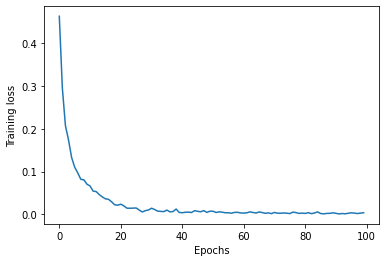

In [11]:
import matplotlib.pyplot as plt
plt.plot(training)
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.show()

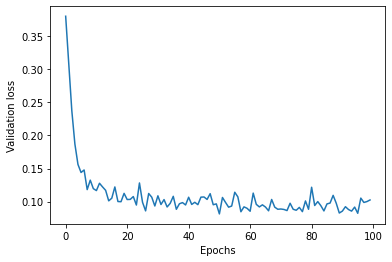

In [12]:
import matplotlib.pyplot as plt
plt.plot(validation)
plt.xlabel("Epochs")
plt.ylabel("Validation loss")
plt.show()